In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_all_years = pd.read_excel('../data/df_all_years.xlsx')
df_all_years.head(1)

,year,facility_id,facility_name,county,address,city,zip_code,facility_group,facility_class,medicare_as_primary_num_of_claims,...,totaladmindischarge,totalinpatientdays,totaloutpatientvisits,totalervisits,total_patients,total_days,total_uninsured_patients,inpatient_charges_credible_insurance_not_available_for_particular_serv,total_expenses,net_profit_loss
0,2023,1455,Knoxville Rehabilitation Hospital,Knox,1250 Tennova Medical Way,Knoxville,37909,Investor-Owned For-Profit,Corporation,0,...,1144,14381,0,0,245,3045,0.0,0.0,18377883.0,3677937.0


In [3]:
df_income = pd.read_excel('../data/df_income_per_capita.xlsx')
df_income.head(1)

,county,pci_2021,pci_2022,pci_2023
0,Anderson,51271,53607,56260


In [4]:
df_pop = pd.read_csv('../data/df_pop.csv')
df_pop.head(1)

,city,county_fips,county,lat,lng,zips
0,Oak Ridge,47001,Anderson,35.9639,-84.2938,37830


In [5]:
facility_summary = (df_all_years.groupby(["year", "facility_id", "facility_name", "county", "facility_group", "facility_class"], as_index=False)
                    .agg({"total_patients": "sum",
                            "totalervisits": "sum",
                            "totaloutpatientvisits": "sum",
                            "totalinpatientdays": "sum",
                            "total_expenses": "sum",
                            "net_profit_loss": "sum",
                            "total_uninsured_patients": "sum" }))
        
facility_summary.head(1)

,year,facility_id,facility_name,county,facility_group,facility_class,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss,total_uninsured_patients
0,2021,179,Methodist Medical Center of Oak Ridge,Anderson,NonGovermental Not-For-Profit,Other Nonprofit Corp,8637,0,129415,44835,0.0,0.0,0.0


In [6]:
facility_summary[facility_summary['facility_id']==1455]

,year,facility_id,facility_name,county,facility_group,facility_class,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss,total_uninsured_patients
323,2022,1455,Knoxville Rehabilitation Hospital,Knox,Investor-Owned For-Profit,Corporation,893,0,0,11226,1.552293e+07,1.364495e+06,4.0
488,2023,1455,Knoxville Rehabilitation Hospital,Knox,Investor-Owned For-Profit,Corporation,250880,0,0,14726144,1.881895e+10,3.766207e+09,0.0


In [7]:
#ratios
facility_summary["profit_margin"] = facility_summary.apply(
    lambda x: x["net_profit_loss"] / x["total_expenses"] if x["total_expenses"] not in [0, None] else 0, axis=1
)
facility_summary["uninsured_rate"] = facility_summary.apply(
    lambda x: x["total_uninsured_patients"] / x["total_patients"] if x["total_patients"] not in [0, None] else 0, axis=1
)
facility_summary["charges_per_patient"] = facility_summary.apply(
    lambda x: x["total_expenses"] / x["total_patients"] if x["total_patients"] not in [0, None] else 0, axis=1
)
facility_summary.head(1)

,year,facility_id,facility_name,county,facility_group,facility_class,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss,total_uninsured_patients,profit_margin,uninsured_rate,charges_per_patient
0,2021,179,Methodist Medical Center of Oak Ridge,Anderson,NonGovermental Not-For-Profit,Other Nonprofit Corp,8637,0,129415,44835,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
facility_summary["er_share"] = facility_summary.apply(
    lambda x: round(x["totalervisits"] / (x["totalervisits"] + x["totaloutpatientvisits"]), 2) if (x["totalervisits"] + x["totaloutpatientvisits"]) > 0 else 0, axis=1
)
facility_summary["inpatient_days_per_patient"] = facility_summary.apply(
    lambda x: round(x["totalinpatientdays"] / x["total_patients"], 2) if x["total_patients"] not in [0, None] else 0, axis=1
)
facility_summary.head(1)

,year,facility_id,facility_name,county,facility_group,facility_class,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss,total_uninsured_patients,profit_margin,uninsured_rate,charges_per_patient,er_share,inpatient_days_per_patient
0,2021,179,Methodist Medical Center of Oak Ridge,Anderson,NonGovermental Not-For-Profit,Other Nonprofit Corp,8637,0,129415,44835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.19


In [9]:
#  County-level Aggregation 
county_summary = (df_all_years.groupby(["year", "county"], as_index=False).agg({ "facility_id": pd.Series.nunique,   # number of facilities
                                                                                "total_patients": "sum",
                                                                                "totalervisits": "sum",
                                                                                "totaloutpatientvisits": "sum",
                                                                                "totalinpatientdays": "sum",
                                                                                "total_expenses": "sum",
                                                                                "net_profit_loss": "sum" }).rename(columns={"facility_id": "num_facilities"}))
county_summary.head(1)

,year,county,num_facilities,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss
0,2021,Anderson,3,9481,0,217719,49462,0.0,0.0


In [10]:
# Merge with Population
if "county_fips" in df_pop.columns and "county_fips" in county_summary.columns:
    county_summary = county_summary.merge(df_pop, on="county_fips", how="left", suffixes=('', '_pop'))
else:
    county_summary = county_summary.merge(df_pop, on="county", how="left", suffixes=('', '_pop'))


if "county" in df_income.columns and "year" in df_income.columns:
    county_summary = county_summary.merge(df_income, left_on=["county", "year"], right_on=["county", "year"], how="left", suffixes=('', '_income'))
else:
    county_summary = county_summary.merge(df_income, on="county", how="left", suffixes=('', '_income'))

county_summary.head(1)

,year,county,num_facilities,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss,city,county_fips,lat,lng,zips,pci_2021,pci_2022,pci_2023
0,2021,Anderson,3,9481,0,217719,49462,0.0,0.0,Oak Ridge,47001,35.9639,-84.2938,37830,51271,53607,56260


In [11]:
county_summary["patients_per_1000"] = county_summary.apply(
    lambda x: round((x["total_patients"] / x["population"]) * 1000, 2) if x.get("population") not in [0, None] else 0, axis=1
)
county_summary["expenses_per_capita"] = county_summary.apply(
    lambda x: round(x["total_expenses"] / x["population"], 2) if x.get("population") not in [0, None] else 0, axis=1
)
county_summary["facilities_per_100k"] = county_summary.apply(
    lambda x: round((x["num_facilities"] / x["population"]) * 100000, 2) if x.get("population") not in [0, None] else 0, axis=1
)

In [12]:
if "income_per_capita" in county_summary.columns:
    county_summary["expenses_vs_income"] = county_summary.apply(
        lambda x: round(x["expenses_per_capita"] / x["income_per_capita"], 2) if x.get("income_per_capita") not in [0, None, 0] else 0, axis=1
    )
    county_summary["patients_vs_income"] = county_summary.apply(
        lambda x: round(x["patients_per_1000"] / x["income_per_capita"], 2) if x.get("income_per_capita") not in [0, None, 0] else 0, axis=1
    )
else:
    for col in ["pci_2021", "pci_2022", "pci_2023"]:
        if col in county_summary.columns:
            county_summary[f"expenses_vs_{col}"] = county_summary.apply(
                lambda x: round(x["expenses_per_capita"] / x[col], 2) if x.get(col) not in [0, None, 0] else 0, axis=1
            )
            county_summary[f"patients_vs_{col}"] = county_summary.apply(
                lambda x: round(x["patients_per_1000"] / x[col], 2) if x.get(col) not in [0, None, 0] else 0, axis=1
            )


In [13]:
statewide = (
    df_all_years.groupby("year", as_index=False)
    .agg({
        "total_patients": "sum",
        "totalervisits": "sum",
        "totaloutpatientvisits": "sum",
        "totalinpatientdays": "sum",
        "total_expenses": "sum",
        "net_profit_loss": "sum"
    })
)
statewide["profit_margin"] = statewide.apply(
    lambda x: round(x["net_profit_loss"] / x["total_expenses"], 2) if x["total_expenses"] not in [0, None] else 0, axis=1
)
statewide.head(1)

,year,total_patients,totalervisits,totaloutpatientvisits,totalinpatientdays,total_expenses,net_profit_loss,profit_margin
0,2021,734967,78420,11739296,4861880,0.0,0.0,0.0


In [14]:
#save 
output_file = "../data/allyears_pop.xlsx"
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    facility_summary.to_excel(writer, sheet_name="Facility_Summary", index=False)
    county_summary.to_excel(writer, sheet_name="County_Summary", index=False)
    statewide.to_excel(writer, sheet_name="Statewide_Trends", index=False)

output_file


'../data/allyears_pop.xlsx'

In [15]:

facility_summary_out = facility_summary.copy()
facility_summary_out["data_level"] = "facility"

county_summary_out = county_summary.copy()
county_summary_out["data_level"] = "county"

statewide_out = statewide.copy()
statewide_out["data_level"] = "statewide"

common_cols = set(facility_summary_out.columns) | set(county_summary_out.columns) | set(statewide_out.columns)

def ensure_all_columns(df, all_cols):
    for col in all_cols:
        if col not in df.columns:
            df[col] = None
    return df[list(all_cols)]

facility_summary_out = ensure_all_columns(facility_summary_out, common_cols)
county_summary_out = ensure_all_columns(county_summary_out, common_cols)
statewide_out = ensure_all_columns(statewide_out, common_cols)


all_data = pd.concat([facility_summary_out, county_summary_out, statewide_out], ignore_index=True)

# Save outputs 
output_excel = "../data/capstone_analysis.xlsx"
output_csv = "../data/capstone_all_levels.csv"

with pd.ExcelWriter(output_excel, engine="openpyxl") as writer:
    facility_summary.to_excel(writer, sheet_name="Facility_Summary", index=False)
    county_summary.to_excel(writer, sheet_name="County_Summary", index=False)
    statewide.to_excel(writer, sheet_name="Statewide_Trends", index=False)

all_data.to_csv(output_csv, index=False)

output_excel, output_csv


C:\Users\nnavy\AppData\Local\Temp\ipykernel_9652\4196709325.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([facility_summary_out, county_summary_out, statewide_out], ignore_index=True)


('../data/capstone_analysis.xlsx', '../data/capstone_all_levels.csv')

In [16]:
#facility_level
facility_long = facility_summary.melt(
    id_vars=["year", "facility_id", "facility_name", "county"],
    var_name="metric",
    value_name="value"
)
facility_long["data_level"] = "facility"

# County-level 
county_long = county_summary.melt(
    id_vars=["year", "county"],
    var_name="metric",
    value_name="value"
)
county_long["data_level"] = "county"

# Statewide  
statewide_long = statewide.melt(
    id_vars=["year"],
    var_name="metric",
    value_name="value"
)
statewide_long["data_level"] = "statewide"

# Combine all 
all_long = pd.concat([facility_long, county_long, statewide_long], ignore_index=True)

# Save tidy dataset
#output_csv = "../data/capstone_all_levels_long.csv"
#all_long.to_csv(output_csv, index=False)

#output_csv


In [17]:
df_all_years.columns

Index(['year', 'facility_id', 'facility_name', 'county', 'address', 'city',
       'zip_code', 'facility_group', 'facility_class',
       'medicare_as_primary_num_of_claims', 'comm_bcbs_as_payer_num_of_claims',
       'other_payer_as_primary_num_of_claims',
       'medicare_claims_inpatient_total_charges',
       'medicare_claims_outpatient_total_charges',
       'medicare_claims_inpatient_total_payment',
       'medicare_claims_outpatient_total_payment',
       'comm_blue_cross_blue_shield_inpatient_total_charges',
       'comm_blue_cross_blue_shield_outpatient_total_charges',
       'comm_blue_cross_blue_shield_inpatient_total_payment',
       'comm_blue_cross_blue_shield_outpatient_total_payment',
       'other_payer_claims_inpatient_total_charges',
       'other_payer_claims_outpatient_total_charges',
       'other_payer_claims_inpatient_total_payment',
       'other_payer_claims_outpatient_total_payment', 'total_uninsured',
       'uninsured_inpatient_charges', 'uninsured_outpatie

In [18]:
summary = df_all_years.groupby([ "year"]).agg(
    facilities_per_10k = ("facility_id", lambda x: len(x) / (df_all_years.loc[x.index, "population"].iloc[0] / 10000) 
                          if "population" in df_all_years.columns else len(x)), 
    avg_er_visits = ("totalervisits", "mean"),
    total_patients_sum = ("total_patients", "sum"),
    avg_total_expenses = ("total_expenses", "mean")
).reset_index()

In [19]:
summary

,year,facilities_per_10k,avg_er_visits,total_patients_sum,avg_total_expenses
0,2021,161,487.080745,734967,NaN
1,2022,166,603.042169,725996,1.598662e+08
2,2023,1194,106.231993,997768,3.753963e+07


In [20]:
insured_summary = df_all_years.groupby(["county", "year"]).agg( total_patients_sum=("total_patients", "sum"),
                                                                total_uninsured_patients_sum=("total_uninsured_patients", "sum")).reset_index()
insured_summary

,county,year,total_patients_sum,total_uninsured_patients_sum
0,Anderson,2021,9481,0.0
1,Anderson,2022,8713,6960.0
2,Anderson,2023,9207,242.0
3,Bedford,2021,857,0.0
4,Bedford,2022,1002,4342.0
...,...,...,...,...
215,Williamson,2022,14608,6.0
216,Williamson,2023,14385,0.0
217,Wilson,2021,4935,0.0
218,Wilson,2022,5859,3796.0


In [21]:
insured_summary["uninsured_pct"] = (insured_summary["total_uninsured_patients_sum"] / insured_summary["total_patients_sum"]) * 100
insured_summary["insured_pct"] = 100 - insured_summary["uninsured_pct"]

In [22]:
df_all_years.columns

Index(['year', 'facility_id', 'facility_name', 'county', 'address', 'city',
       'zip_code', 'facility_group', 'facility_class',
       'medicare_as_primary_num_of_claims', 'comm_bcbs_as_payer_num_of_claims',
       'other_payer_as_primary_num_of_claims',
       'medicare_claims_inpatient_total_charges',
       'medicare_claims_outpatient_total_charges',
       'medicare_claims_inpatient_total_payment',
       'medicare_claims_outpatient_total_payment',
       'comm_blue_cross_blue_shield_inpatient_total_charges',
       'comm_blue_cross_blue_shield_outpatient_total_charges',
       'comm_blue_cross_blue_shield_inpatient_total_payment',
       'comm_blue_cross_blue_shield_outpatient_total_payment',
       'other_payer_claims_inpatient_total_charges',
       'other_payer_claims_outpatient_total_charges',
       'other_payer_claims_inpatient_total_payment',
       'other_payer_claims_outpatient_total_payment', 'total_uninsured',
       'uninsured_inpatient_charges', 'uninsured_outpatie

In [23]:
er_visits_df = df_all_years[['year','under15ervisits','15to17ervisits','18to64ervisits','65to74ervisits','75to84ervisits','85overervisits']]

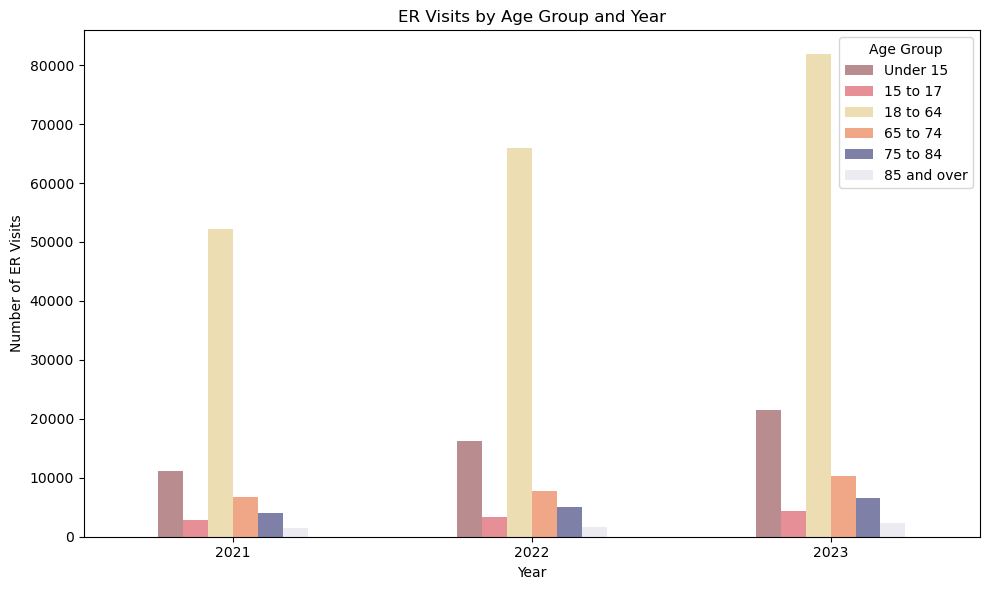

In [24]:

import matplotlib.ticker as mtick

er_visits_by_year = er_visits_df.groupby("year").sum()

age_order = [
    "under15ervisits",
    "15to17ervisits",
    "18to64ervisits",
    "65to74ervisits",
    "75to84ervisits",
    "85overervisits"
]
er_visits_by_year = er_visits_by_year[age_order]

colors = ["#B98C8F", "#E68F96", "#EDDDB3", "#F0A787", "#7e80a8", "#edebf2"]

# Clustered bar chart 
ax = er_visits_by_year.plot(
    kind="bar",
    figsize=(10,6),
    color=colors
)

# Labels and title
plt.title("ER Visits by Age Group and Year")
plt.xlabel("Year")
plt.ylabel("Number of ER Visits")
plt.xticks(rotation=0)
plt.legend(title="Age Group", labels=[
    "Under 15",
    "15 to 17",
    "18 to 64",
    "65 to 74",
    "75 to 84",
    "85 and over"
])

# Disable scientific notation 
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# save
plt.tight_layout()
plt.savefig("../visual_templates/er_visits_by_year_clustered.png", dpi=300)
plt.show()


In [25]:
out_patients_df = df_all_years[['year','under15outpatientvisits','15to17outpatientvisits','18to64outpatientvisits','65to74outpatientvisits','75to84outpatientvisits','85overoutpatientvisits']]

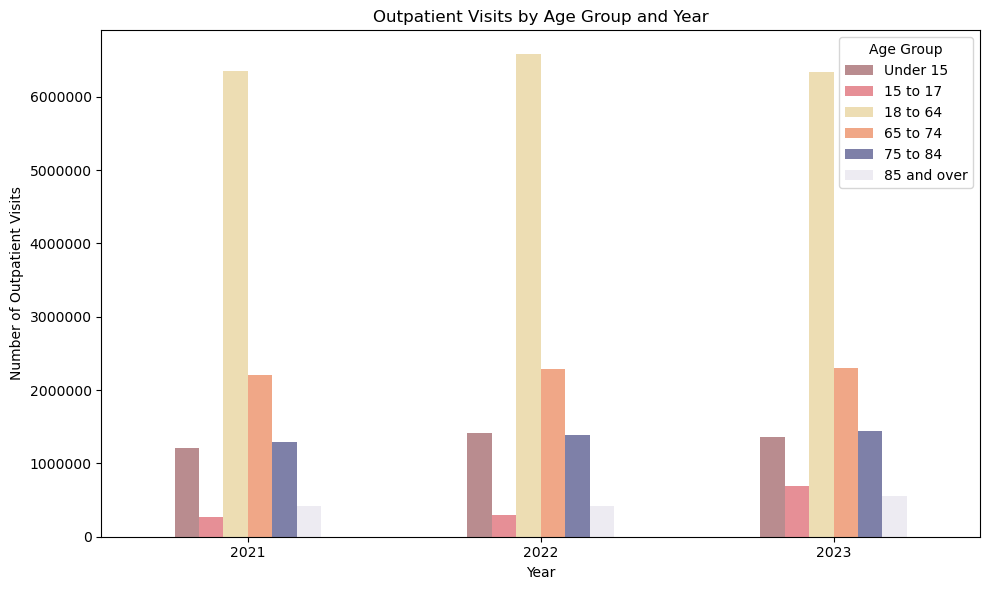

In [26]:

out_patients_by_year = out_patients_df.groupby("year").sum()

age_order = [
    "under15outpatientvisits",
    "15to17outpatientvisits",
    "18to64outpatientvisits",
    "65to74outpatientvisits",
    "75to84outpatientvisits",
    "85overoutpatientvisits"
]
out_patients_by_year = out_patients_by_year[age_order]

colors = ["#B98C8F", "#E68F96", "#EDDDB3", "#F0A787", "#7e80a8", "#edebf2"]

# --- Clustered bar chart ---
ax = out_patients_by_year.plot(
    kind="bar",
    figsize=(10,6),
    color=colors
)

# --- Labels and title ---
plt.title("Outpatient Visits by Age Group and Year")
plt.xlabel("Year")
plt.ylabel("Number of Outpatient Visits")
plt.xticks(rotation=0)
plt.legend(title="Age Group", labels=[
    "Under 15",
    "15 to 17",
    "18 to 64",
    "65 to 74",
    "75 to 84",
    "85 and over"
])


#  Disable scientific notation 
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# Save figure
plt.tight_layout()
plt.savefig("../visual_templates/outpatient_visits_by_year_clustered.png", dpi=300)
plt.show()


In [27]:
inpatients_df = df_all_years[['year','under15patientdays','15to17patientdays','18to64patientdays','65to74patientdays','75to84patientdays','85overpatientdays']]

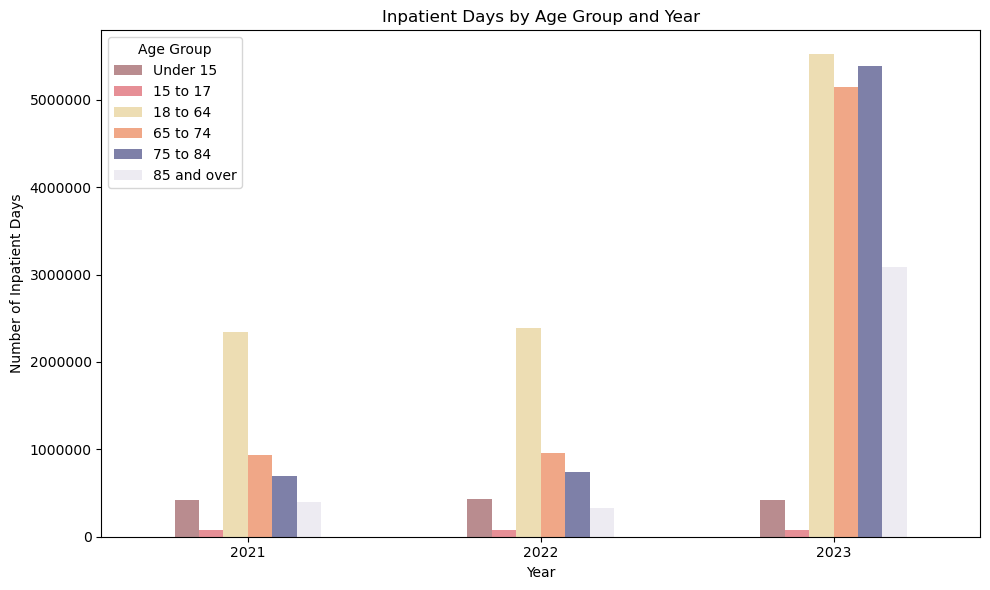

In [28]:

inpatients_by_year = inpatients_df.groupby("year").sum()

age_order = [
    "under15patientdays",
    "15to17patientdays",
    "18to64patientdays",
    "65to74patientdays",
    "75to84patientdays",
    "85overpatientdays"
]
inpatients_by_year = inpatients_by_year[age_order]

colors = ["#B98C8F", "#E68F96", "#EDDDB3", "#F0A787", "#7e80a8", "#edebf2"]

# Clustered bar chart 
ax = inpatients_by_year.plot(
    kind="bar",
    figsize=(10,6),
    color=colors
)

#  Labels and title 
plt.title("Inpatient Days by Age Group and Year")
plt.xlabel("Year")
plt.ylabel("Number of Inpatient Days")
plt.xticks(rotation=0)
plt.legend(title="Age Group", labels=[
    "Under 15",
    "15 to 17",
    "18 to 64",
    "65 to 74",
    "75 to 84",
    "85 and over"
])

# Disable scientific notation 
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# save
plt.tight_layout()
plt.savefig("../visual_templates/inpatient_days_by_year_clustered.png", dpi=300)
plt.show()
